In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
from data_process.shadow_render import render_shadow
import matplotlib.pyplot as plt

import torch
from ssn import ssn_dataset
from torchvision import transforms, utils
import numpy as np
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Testing relative vectors

In [ ]:
# generate ibls(rotating around)
def to_mask(img):
    img = (img[:,:,0] + img[:,:,1] + img[:,:,2])/3.0
    img = img/np.max(img)
    return img

# relative_vec = np.array([0.108, 2.64, 1.8])
# ibl_img = to_mask(render_shadow(relative_vec))

# Generate 256 x 512 ibls

In [ ]:
output_folder = '/home/ysheng/Documents/adobe_shadow_net/testing_lights/'
import os

os.makedirs(output_folder,exist_ok=True)
h,w = 256,512
counter = 0
for i in range(h):
    for j in range(w):
        fname = '{:07d}.png'.format(counter)
        img = np.zeros((h,w))
        img[i,j] = 1.0
        plt.imsave(os.path.join(output_folder, fname), img)
        counter += 1
print('finished')

# Render predictions  

In [30]:
from valid_relight_ssn import predict
from tqdm import tqdm
from PIL import Image
from ssn.ssn_dataset import Mask_Transform, IBL_Transform, ToTensor
import os 
def show_np(img):
    plt.figure()
    plt.imshow(img)

def to_one_batch(img_tensor):
    c,h,w = img_tensor.size()
    return img_tensor.view(1,c,h,w)

def to_numpy(one_batch):
    return one_batch[0].detach().cpu().numpy().transpose((1,2,0))

def real_to_mask(img):
    print(np.max(img))
    h,w,c = img.shape
    mask = np.zeros((h,w,3), dtype=np.uint8)
    mask[:,:,0],mask[:,:,1],mask[:,:,2]  = img[:,:,3], img[:,:,3], img[:,:,3]
    
    print(np.max(mask))
    
    return mask

In [31]:
from valid_relight_ssn import get_model
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = get_model()

Device:  cuda:1


Dataset initialize spent: 0.7077696323394775 ms
('/home/ysheng/Dataset/soft_shadow/train/sofa_0404_normalize', '0_1.09648_1.81262', "['270']")


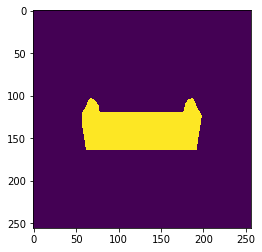

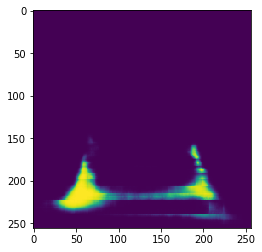

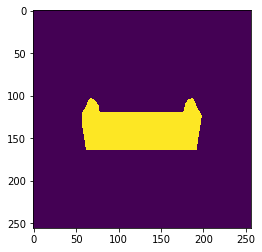

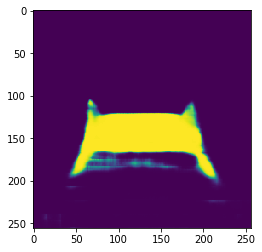

In [46]:
csv_file = "~/Dataset/soft_shadow/train/metadata.csv"
# compose_transform = None
training_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = True)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=False)
print(training_dataset.keys[0])
target_folder = training_dataset.keys[0][0]

counter = 0
model.eval()
dataloader_mask = None
dataloader_light = None

with torch.no_grad():
    for i, (mask, light, shadow, nov_mask, nov_light, nov_shadow) in enumerate(dataloader):
        zeros_shadow = 0.0 * shadow
        dataloader_mask = mask
        dataloader_light = nov_light
        I_s = torch.cat((mask, zeros_shadow), dim=1).to(device)
        L_t = nov_light.to(device)

        predicted_img, predicted_src_light = model(I_s, L_t)
        
        predicted_img = predicted_img[0].detach().cpu().numpy().transpose((1,2,0))
        shadow = predicted_img[:,:,1]
        
        mask_np = mask[0].detach().cpu().numpy().transpose((1,2,0))
        show_np(mask_np[:,:,0])
        show_np(shadow)
        
        I_s = torch.cat((mask, mask), dim=1).to(device)
        L_t = nov_light.to(device)

        predicted_img, predicted_src_light = model(I_s, L_t)
        
        predicted_img = predicted_img[0].detach().cpu().numpy().transpose((1,2,0))
        shadow = predicted_img[:,:,1]
        
        mask_np = mask[0].detach().cpu().numpy().transpose((1,2,0))
        show_np(mask_np[:,:,0])
        show_np(shadow)
        
        counter += 1
        
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 16, 32])


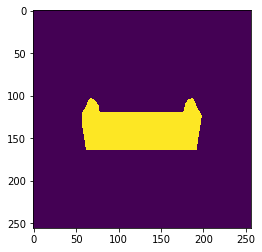

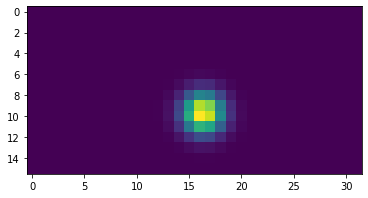

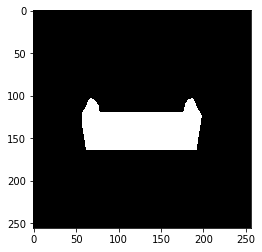

In [33]:
print(dataloader_mask.shape)
print(dataloader_light.shape)
dl_mask_np = to_numpy(dataloader_mask)
dl_light_np = to_numpy(dataloader_light)

dl_mask_np = dl_mask_np.reshape(256,256)
dl_light_np = dl_light_np.reshape(16,32)
show_np(dl_mask_np)
show_np(dl_light_np)

h,w = dl_mask_np.shape
testing_np = np.zeros((h,w,3))
testing_np[:,:,0], testing_np[:,:,1], testing_np[:,:,2] = dl_mask_np, dl_mask_np, dl_mask_np
testing_np = testing_np * 255.0

show_np(testing_np)



  0%|          | 0/131584 [00:00<?, ?it/s]


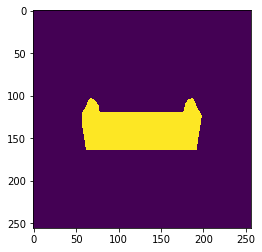

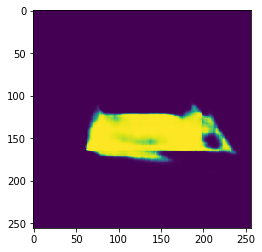

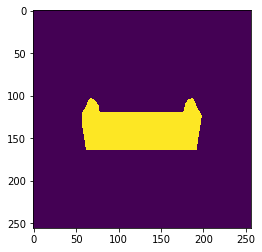

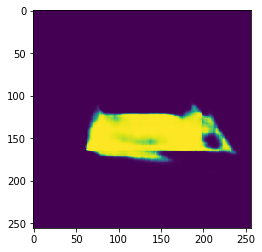

In [47]:
import random

output_folder = '/home/ysheng/Documents/adobe_shadow_net/testing_lights/'
prediction_result_folder = '/home/ysheng/Documents/adobe_shadow_net/results/animations/'

# testing_fname = '/home/ysheng/Dataset/soft_shadow/train/bed_0278_normalize/imgs/0000325_mask.png'
# testing_fname = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_A/imgs/0000000_mask.png'
testing_fname = os.path.join(target_folder, 'imgs/0000355_mask.png')
testing_img = Image.open(testing_fname)

testing_ibl_fnames = [f for f in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, f))]
random.shuffle(testing_ibl_fnames)
counter = 1

img_trnsf = transforms.Compose([
    Mask_Transform(),
    ToTensor()
])
ibl_trnsf = transforms.Compose([
    IBL_Transform(),
    ToTensor()
])
    
for ibl_file in tqdm(testing_ibl_fnames):
    prefix = os.path.splitext(ibl_file)[0]
    out_file = '{}.png'.format(prefix)
    predict_fname = os.path.join(prediction_result_folder, out_file)
    
    tmp_ibl = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_claudia_margita_Base_Pose_Standing_A/imgs/0000100_light.png'
    # ibl_img = Image.open(os.path.join(output_folder, ibl_file))
    
    # mask, shadow = predict(testing_img, ibl_img)
    ibl_tensor = to_one_batch(ibl_trnsf(Image.open(tmp_ibl)))
    

    I_s = torch.cat((dataloader_mask, dataloader_mask), dim=1).to(device)
    L_t = ibl_tensor.to(device)
    
    predict_res, light_res = model(I_s,L_t)
    
    predict_res_np = to_numpy(predict_res)
    mask, shadow = predict_res_np[:,:,0],predict_res_np[:,:,1]
    show_np(mask)
    show_np(shadow)
    
    mask_tensor = to_one_batch(img_trnsf(testing_img))
    I_s = torch.cat((mask_tensor, mask_tensor), dim=1).to(device)
    L_t = ibl_tensor.to(device)
    
    predict_res, light_res = model(I_s,L_t)
    
    predict_res_np = to_numpy(predict_res)
    mask, shadow = predict_res_np[:,:,0],predict_res_np[:,:,1]
    show_np(mask)
    show_np(shadow)
    
    counter += 1
    
    break

# Make animations

/home/ysheng/Dataset/soft_shadow/train/sofa_0404_normalize
